# Find subnets implemented using mnist

## Imports

In [ ]:
!git clone https://github.com/arunraja-hub/Preference_Extraction.git

fatal: destination path 'Preference_Extraction' already exists and is not an empty directory.


In [ ]:
!nvidia-smi

Sat Sep 26 09:05:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## If you are running on Google Colab, please install TensorFlow 2.0 by uncommenting below..
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
from __future__ import print_function
import argparse
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
import torch.autograd as autograd
from torchsummary import summary

from sklearn.utils import shuffle
import tensorflow as tf
import concurrent.futures
import itertools
import os
import random
import sys
import time
import re
import io
import itertools
import sys

sys.path.append('Preference_Extraction')
from imports_data import all_load_data

In [ ]:
params = {}
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

## Load Data

In [ ]:
# Data source options, choices: 'mnist', 'grid' and 'doom'
params['env'] = 'doom' 

In [ ]:
# Load doom data from GCP storage, run only if env == doom
# Requires GCP authentication
from google.colab import auth
auth.authenticate_user()
!gsutil cp gs://pref-extr-data/agentv29/experienceData.pkl experienceData.pkl

Copying gs://pref-extr-data/agentv29/experienceData.pkl...
- [1 files][  1.3 GiB/  1.3 GiB]   69.6 MiB/s                                   
Operation completed over 1 objects/1.3 GiB.                                      


In [ ]:
# Data Loader
xs = []
ys = []

if params['env'] == 'grid':
    # original pref extraction data
    all_raw_data = all_load_data("Preference_Extraction/data/simple_env_1/")
    for data in all_raw_data:
        for i in range(data.observation.shape[0]):
            x = np.copy(data.observation[i])
            y = (data.policy_info['satisfaction'].as_list()[i] > -6).astype(int)

            xs.append(x)
            ys.append(y)

    ys = np.array(ys)
    xs = np.rollaxis(np.array(xs), 3, 1) # Torch wants channel-first

elif params['env'] == 'doom':
    all_raw_data = joblib.load('/content/experienceData.pkl')
    for data in all_raw_data:
        for i in range(data.observation.shape[0]):
            x = np.copy(data.observation[i])
            label_object = data.policy_info['satisfaction'][i]
            if len(label_object) == 0: # When label is empty, i.e. human is dead, skip frame
                continue
            else:
                y = label_object['object_angle'] < 90 or label_object['object_angle'] > 270

            xs.append(x)
            ys.append(y)
    
    ys = np.array(ys)
    xs = np.rollaxis(np.array(xs), 3, 1) # Torch wants channel-first

elif params['env'] == 'mnist':
    mnist_choice = 3 # Change this value to do binary classification against other mnist digit
    (mnist_xs, mnist_ys), _ = tf.keras.datasets.mnist.load_data()
    for ix, label in enumerate(mnist_ys):
        x = np.copy(mnist_xs[ix])
        y = (label == mnist_choice).astype(int)

        xs.append(x)
        ys.append(y)

    ys = np.array(ys)
    xs = np.array(xs) # Mnist has no channels

else:
    print('Invalid enviroment choice!!')

print("xs", xs.shape, "ys", ys.shape)
print("ys 1", np.sum(ys))

xs (7830, 6, 60, 100) ys (7830,)
ys 1 1828


In [ ]:
# Rebalancing data to minority class
points = xs
labels = ys

# indexes of 1s and 0s
indexes1 = [i for i in range(len(points)) if labels[i] == 1]
indexes0 = [i for i in range(len(points)) if labels[i] == 0]

# separate 0s and 1s
x0, x1, y0, y1 = points[indexes0], points[indexes1], labels[indexes0], labels[indexes1]

minority_points, minority_labels = x1, y1  # points and labels for the minority class
majority_points, majority_labels = x0, y0  # points and labels for the majority class

# get a random permutation of indexes of the majority that includes a number of indexes equal to the minority
sample_ind = np.random.permutation(len(majority_labels))[:len(minority_labels)]

# subsample the majority
majority_points, majority_labels = majority_points[sample_ind], majority_labels[sample_ind]

# concat the minority and the sub-sampled majority
xs = np.concatenate((majority_points, minority_points))
ys = np.concatenate((majority_labels, minority_labels))

print("xs", xs.shape, "ys", ys.shape)
print("ys 1", np.sum(ys))
xs, ys = shuffle(xs, ys)

xs (3656, 6, 60, 100) ys (3656,)
ys 1 1828


## Nets and Subnets Architectures

In [ ]:
"""
    Original code from What's hidden in a randomly weighted neural network? paper
    Implemented at https://github.com/allenai/hidden-networks
    Remove weigths-initialisation since it is not relevant for us
"""

class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

class SupermaskConv(nn.Conv2d):
    def __init__(self, *args, k, scores_init='kaiming_uniform', **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k
        self.scores_init = scores_init

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        if self.scores_init == 'kaiming_normal':
          nn.init.kaiming_normal_(self.scores)
        elif self.scores_init == 'kaiming_uniform':
          nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        elif self.scores_init == 'xavier_normal':
          nn.init.xavier_normal_(self.scores)
        elif self.scores_init == 'best_activation':
          nn.init.ones_(self.scores)
        else:
          nn.init.uniform_(self.scores)

        # initialize the weights
        nn.init.uniform_(self.weight)
        
        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

class SupermaskLinear(nn.Linear):
    def __init__(self, *args, k, scores_init='kaiming_uniform', **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k
        self.scores_init = scores_init

        # initialize the scores and weights
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        if self.scores_init == 'kaiming_normal':
          nn.init.kaiming_normal_(self.scores)
        elif self.scores_init == 'kaiming_uniform':
          nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))
        elif self.scores_init == 'xavier_normal':
          nn.init.xavier_normal_(self.scores)
        elif self.scores_init == 'best_activation':
          nn.init.ones_(self.scores)
        else:
          nn.init.uniform_(self.scores)

        nn.init.uniform_(self.weight)

        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        return F.linear(x, w, self.bias)
        return x

# NOTE: not used here but we use NON-AFFINE Normalization!
# So there is no learned parameters for your nomralization layer.
class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

In [ ]:
class PrefQNet(nn.Module):
    """
      If q_head_index is None, this uses a linear model on the normalized q outputs.
      Otherwise, it gets the Q head with the specified index.
    """ 
    def __init__(self, fine_tune, k, q_head_index, q_means_stds, use_last_linear, init_from_act_index=None):
        super(PrefQNet, self).__init__()
        
        if not params['use_mnist']:
            channels_in = 5
            flattened_shape = 960
        else:
            channels_in = 1
            flattened_shape = 4608

        if fine_tune:
            conv_layer = nn.Conv2d
            dense_layer = nn.Linear
            additional_args = {}
            init_from_act_index = None
        else:
            conv_layer = SupermaskConv
            dense_layer = SupermaskLinear
            additional_args = {'k': k}
            if init_from_act_index is not None:
                additional_args['scores_init'] = 'best_activation'
        
        self.conv1 = conv_layer(in_channels=channels_in, out_channels=16, kernel_size=3, stride=1, bias=True, **additional_args)
        self.conv2 = conv_layer(in_channels=16, out_channels=32, kernel_size=3, stride=2, bias=True, **additional_args)
        self.fc1 = dense_layer(in_features=flattened_shape, out_features=64, bias=True, **additional_args)
        self.fc2 = dense_layer(in_features=64, out_features=3, bias=True, **additional_args)
        
        if init_from_act_index is not None:
            init_scores = np.zeros((3, 64))
            init_scores[:, init_from_act_index] = 1.0
            self.fc2.scores.data = torch.from_numpy(init_scores).float()

        self.fc3 = dense_layer(in_features=3, out_features=1, bias=True, **additional_args)
        self.linear = nn.Linear(1, 1, bias=True)

        self.qix = q_head_index
        self.qu_mu_s = q_means_stds
        self.use_last_linear = use_last_linear

    def fwd_conv1(self, x):
        x = self.conv1(x)
        return F.relu(x)

    def fwd_conv2(self, x):
        x = self.fwd_conv1(x)
        x = self.conv2(x)
        return F.relu(x)

    def fwd_flat(self, x):
        x = self.fwd_conv2(x)
        return torch.flatten(torch.transpose(x, 1, 3), 1) # Pre-flattening transpose is necessary for TF-Torch conversion

    def fwd_fc1(self, x):
        x = self.fwd_flat(x)
        x = self.fc1(x)
        return F.relu(x)
    
    def fwd_fc2(self, x):
        x = self.fwd_fc1(x)
        return self.fc2(x)

    def forward(self, x):
        x = self.fwd_fc2(x)

        x -= torch.tensor(self.qu_mu_s[0], device=device)
        x /= torch.tensor(self.qu_mu_s[1], device=device)

        if self.qix == None:
          x = self.fc3(x)
        else:
          x = x[: ,self.qix:self.qix+1]

        if self.use_last_linear:
          x = self.linear(x)

        x = torch.sigmoid(x)
        return x.flatten()

    def load_weights(self, original_weights):
        if not params['use_mnist']:
            self.conv1.weight.data = torch.from_numpy(np.transpose(original_weights[0]))
            self.fc1.weight.data = torch.from_numpy(np.transpose(original_weights[4]))
        else:
            self.conv1.weight.data = torch.from_numpy(np.transpose(original_weights[0][:,:,:1,:]))
            mnist_flt_weights = np.random.rand(64, 4608)
            mnist_flt_weights[:, :original_weights[4].shape[0]] = np.transpose(original_weights[4])
            mnist_flt_weights = mnist_flt_weights.astype(np.float32)
            self.fc1.weight.data = torch.from_numpy(mnist_flt_weights)

        self.conv1.bias.data = torch.from_numpy(original_weights[1])
        self.conv2.weight.data = torch.from_numpy(np.transpose(original_weights[2]))
        self.conv2.bias.data = torch.from_numpy(original_weights[3])
        self.fc1.bias.data = torch.from_numpy(original_weights[5])
        self.fc2.weight.data = torch.from_numpy(np.transpose(original_weights[6]))
        self.fc2.bias.data = torch.from_numpy(original_weights[7])
        self.fc3.weight.data = torch.from_numpy(np.ones(shape=[1,3], dtype=np.float32))
        self.fc3.bias.data = torch.from_numpy(np.zeros(shape=[1], dtype=np.float32))
        self.to(device)

In [ ]:
class PPOMaskNet(nn.Module):
    """
    A simple torch network to apply supermask techniques on Doom Agent
    """ 
    def __init__(self, fine_tune, k, use_last_linear,
                 means_stds=[[0, 0, 0], [1, 1, 1]],
                 dropout=None,
                 init_from_act_index=None):
        super(PPOMaskNet, self).__init__()
        
        if fine_tune:
            conv_layer = nn.Conv2d
            dense_layer = nn.Linear
            additional_args = {}
            init_from_act_index = None
        else:
            conv_layer = SupermaskConv
            dense_layer = SupermaskLinear
            additional_args = {'k': k}
            if init_from_act_index is not None:
                additional_args['scores_init'] = 'best_activation'
        
        self.fc1 = dense_layer(in_features=36000, out_features=200, bias=True, **additional_args)
        self.fc2 = dense_layer(in_features=200, out_features=100, bias=True, **additional_args)
        #self.fc3 = dense_layer(in_features=100, out_features=4, bias=True, **additional_args)
        #self.fc4 = dense_layer(in_features=4, out_features=1, bias=True, **additional_args)
        self.drop = None
        if dropout is not None:
            self.drop = nn.Dropout(p=dropout)
        self.linear = nn.Linear(100, 1, bias=True)
        self.use_last_linear = use_last_linear

        self.mu_s = means_stds

    def fwd_flat(self, x):
        return torch.flatten(torch.transpose(x, 1, 3), 1) # Pre-flattening transpose is necessary for TF-Torch conversion

    def fwd_fc1(self, x):
        x = self.fwd_flat(x)
        x = self.fc1(x)
        return F.relu(x)
    
    def fwd_fc2(self, x):
        x = self.fwd_fc1(x)
        x = self.fc2(x)
        return F.relu(x)

    def fwd_fc3(self, x):
        x = self.fwd_fc2(x)
        return self.fc3(x)

    def fwd_fc4(self, x):
        x = self.fwd_fc3(x)
        return self.fc4(x)

    def forward(self, x):
        x = self.fwd_fc2(x)
        x -= torch.tensor(self.mu_s[0], device=device)
        x /= torch.tensor(self.mu_s[1], device=device)

        if self.use_last_linear:
            if self.drop is not None:
                x = self.drop(x)
            x = self.linear(x)

        x = torch.sigmoid(x)
        return x.flatten()

    def load_weights(self, original_weights):
        self.fc1.weight.data = torch.from_numpy(np.transpose(original_weights[0]))
        self.fc1.bias.data = torch.from_numpy(original_weights[1])
        self.fc2.weight.data = torch.from_numpy(np.transpose(original_weights[2]))
        self.fc2.bias.data = torch.from_numpy(original_weights[3])
        #self.fc3.weight.data = torch.from_numpy(np.transpose(original_weights[4]))
        #self.fc3.bias.data = torch.from_numpy(original_weights[5])
        #self.fc4.weight.data = torch.from_numpy(np.ones(shape=[1, 4], dtype=np.float32))
        #self.fc4.bias.data = torch.from_numpy(np.zeros(shape=[1], dtype=np.float32))
        self.to(device)

## Loading Weights

In [ ]:
!gsutil cp gs://pref-extr-data/agentv29/actorNet.keras actorNet.keras

Copying gs://pref-extr-data/agentv29/actorNet.keras...
/ [1 files][ 27.6 MiB/ 27.6 MiB]                                                
Operation completed over 1 objects/27.6 MiB.                                     


In [ ]:
# Shortlisting different agents
dqn_grid_path = "Preference_Extraction/saved_model2"
ppo_doom_path = "/content/actorNet.keras"

In [ ]:
# Choose agent to use
model_path = ppo_doom_path
params['agent_path'] = model_path

In [ ]:
restored_model = tf.keras.models.load_model(model_path)
restored_model.summary()
original_weights = restored_model.get_weights()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (1, 36000)                0         
_________________________________________________________________
dense (Dense)                (1, 200)                  7200200   
_________________________________________________________________
dense_1 (Dense)              (1, 100)                  20100     
_________________________________________________________________
logits (Dense)               (1, 4)                    404       
Total params: 7,220,704
Trainable params: 7,220,704
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if params['env'] != 'doom':
    test_model = PrefQNet(k=1, fine_tune=False, q_head_index=None, q_means_stds=[[0, 0, 0], [1, 1, 1]], use_last_linear=True).to(device)
else:
    test_model = PPOMaskNet(k=1, fine_tune=False, use_last_linear=True).to(device)

test_model.load_weights(original_weights)

In [ ]:
# Testing that weigths loaded property
# Change this list to test different torch models
torch_model_layers = [test_model.fwd_fc1, 
                      test_model.fwd_fc2]
                      #test_model.fwd_fc3]

def check_same(torch_layer, tf_layer):
    torch_out = np.transpose(torch_layer(single_observation_torch).detach().cpu().numpy())
    torch_out = torch_out.reshape(torch_out.shape[:-1])
    tf_out = tf_layer(single_observation)[0].numpy()
    np.testing.assert_allclose(torch_out, tf_out, rtol=.1, atol=5)  

for i in range(100):
    single_observation = np.array([xs[i]])
    single_observation_torch = torch.Tensor(np.array([np.transpose(xs[i])]))
    single_observation_torch = single_observation_torch.to(device)
    
    index_shift = 0
    for ix, original_lyr in enumerate(restored_model.layers):
        if ix < len(torch_model_layers):
            if original_lyr.name == 'flatten':
                index_shift = 1
            else:
                tf_sub_model = tf.keras.models.Model(inputs=restored_model.input, outputs=original_lyr.output)
                check_same(torch_model_layers[ix-index_shift], tf_sub_model)

### Get data to normalize outputs

In [ ]:
def get_heads_mu_and_sigma(model, all_obs, num_obs):
    
    model.eval()

    all_obs = shuffle(all_obs)
    obs_to_pass = all_obs[:num_obs]

    obs_tensor = torch.Tensor(obs_to_pass)
    obs_tensor = obs_tensor.to(device)
    heads_values = model.fwd_fc2(obs_tensor).detach().cpu().numpy()

    mu = heads_values.mean(axis=0)
    s = heads_values.std(axis=0)
    s[s == 0] = 1
    print("mu", mu, "s", s)
    
    return np.array([mu, s])

mu_s = get_heads_mu_and_sigma(test_model, xs, 500)

mu [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.13397194e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.92282715e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.80466369e-02
 0.00000000e+00 0.00000000e+00 8.93991351e-01 1.86095474e+02
 0.00000000e+00 8.62564668e-02 5.36296988e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.12318611e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.87620735e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.68521385e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.875

### Method to get data for one sample run

In [ ]:
params['num_train'] = 500
params['num_val'] = 500
params['batch_size'] = 128

def get_data_sample(xs=None, ys=None):
    xs, ys = shuffle(xs, ys)
    
    train_split = params['num_train']
    test_split = params['num_train']+params['num_val']

    tr_data_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.Tensor(xs[:train_split]), torch.Tensor(ys[:train_split])),
        batch_size=params['batch_size'])
    
    val_data_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.Tensor(xs[train_split:test_split]), torch.Tensor(ys[train_split:test_split])),
        batch_size=params['batch_size'])
    
    return tr_data_loader, val_data_loader

### Single run train/test methods

In [ ]:
"""
    Train/Test function for Randomly Weighted Hidden Neural Networks Techniques
    Adapted from https://github.com/NesterukSergey/hidden-networks/blob/master/demos/mnist.ipynb
"""

def compute_metrics(predictions, true_labels):
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = np.sum(np.equal((predictions > 0.5).astype(int), true_labels)) / len(true_labels)
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, predictions)
    auc = metrics.auc(fpr, tpr)
    return accuracy, auc

def train(model, device, train_loader, optimizer, criterion):
    
    train_loss = 0
    true_labels = []
    predictions = [] # labels

    model.train()

    for data, target in itertools.islice(train_loader, params['num_train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss
        predictions.extend(output.detach().cpu().numpy())
        true_labels.extend(target.detach().cpu().numpy())
    
    train_loss /= len(train_loader.dataset)
    accuracy, auc = compute_metrics(predictions, true_labels)

    return train_loss.item(), accuracy, auc

def test(model, device, criterion, test_loader, num_test):
    true_labels = []
    predictions = [] # labels

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in itertools.islice(test_loader, num_test):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            predictions.extend(output.detach().cpu().numpy())
            true_labels.extend(target.detach().cpu().numpy())
    
    test_loss /= len(test_loader.dataset)
    accuracy, auc = compute_metrics(predictions, true_labels)

    return test_loss.item(), accuracy, auc

def run_model(model, learning_rate, weight_decay, num_epochs):

  tr_data_loader, val_data_loader = get_data_sample(xs, ys)

  optimizer = optim.Adam(
      [p for p in model.parameters() if p.requires_grad],
      lr=learning_rate,
      weight_decay=weight_decay
  )

  criterion = nn.BCELoss().to(device)
  scheduler = CosineAnnealingLR(optimizer, T_max=len(tr_data_loader))

  train_losses = []
  test_losses = []
  train_accs = []
  train_aucs = []
  test_accs = []
  test_aucs = []  

  best_test_loss = np.inf
  test_loss_up_since = 0
  early_stop = 50
  verbose = True
  for epoch in range(num_epochs):
      train_loss, train_accuracy, train_auc = train(model, device, tr_data_loader, optimizer, criterion)
      test_loss, test_accuracy, test_auc = test(model, device, criterion, val_data_loader, params['num_val'])
      scheduler.step()
      if test_loss < best_test_loss:
          best_test_loss = test_loss
          test_loss_up_since = 0
      test_loss_up_since += 1
      if test_loss_up_since > early_stop:
          print('Epoch - ', epoch, 'Early stopping')
          break
      if verbose:
          print('Epoch - ', epoch)
          print('Train metrics: loss', train_loss, 'accuracy', train_accuracy, 'auc', train_auc)
          print('Val metrics: loss', test_loss, 'accuracy', test_accuracy, 'auc', test_auc)

      train_losses.append(train_loss)
      test_losses.append(test_loss)
      train_accs.append(train_accuracy)
      train_aucs.append(train_auc)
      test_accs.append(test_accuracy)
      test_aucs.append(test_auc)

  return {'trainLoss': train_losses, 'testLoss': test_losses, 
          'trainAccuracy': train_accs, 'testAccuracy': test_accs,
          'trainAUC': train_aucs, 'testAUC': test_aucs}

def plot_metric(results_dict, metric):
    plt.title(metric)
    plt.xlabel('Epochs')
    plt.plot(list(range(1, len(results_dict[f'train{metric}']) + 1)), results_dict[f'train{metric}'], label=f'Train {metric}')
    plt.plot(list(range(1, len(results_dict[f'train{metric}']) + 1)), results_dict[f'test{metric}'], label=f'Test {metric}')
    plt.legend()
    plt.show()

def multi_runs(model, learning_rate, weight_decay, plots=False):

    averaged_results = {}    
    for run_ix in range(params['num_run']):
 
        results = run_model(model, learning_rate=learning_rate, weight_decay=weight_decay, num_epochs=params['num_epochs'])       
        print(f'Train pass no. {run_ix+1}')

        if (run_ix == 0) and plots:
            print('Debug charts for first training run')
            plot_metric(results, 'Loss')
            plot_metric(results, 'Accuracy')
            plot_metric(results, 'AUC')

        for res in results:
            if len(results[res]) > 0:
                if res not in averaged_results:
                    averaged_results[res] = [results[res][-1]]
                else:
                    averaged_results[res].append(results[res][-1])         
    
    return {x: sum(averaged_results[x]) / params['num_run'] for x in averaged_results}

Epoch -  0
Train metrics: loss 0.0055450135841965675 accuracy 0.5 auc 0.5196963151410423
Val metrics: loss 0.005542377009987831 accuracy 0.514 auc 0.5
Epoch -  1
Train metrics: loss 0.005574568174779415 accuracy 0.498 auc 0.48853581657306516
Val metrics: loss 0.005542497616261244 accuracy 0.514 auc 0.5
Epoch -  2
Train metrics: loss 0.00554695213213563 accuracy 0.474 auc 0.5103201651226419
Val metrics: loss 0.005542566999793053 accuracy 0.514 auc 0.5
Epoch -  3
Train metrics: loss 0.0055999187752604485 accuracy 0.482 auc 0.45725531608505726
Val metrics: loss 0.0055425832979381084 accuracy 0.514 auc 0.5
Epoch -  4
Train metrics: loss 0.0055280644446611404 accuracy 0.568 auc 0.5504328069249108
Val metrics: loss 0.0055425832979381084 accuracy 0.514 auc 0.5
Epoch -  5
Train metrics: loss 0.005524537526071072 accuracy 0.512 auc 0.5382166114657835
Val metrics: loss 0.0055425954051315784 accuracy 0.514 auc 0.5
Epoch -  6
Train metrics: loss 0.005537973716855049 accuracy 0.506 auc 0.5219203507

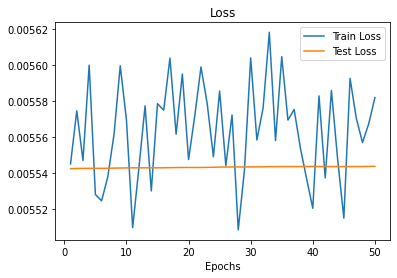

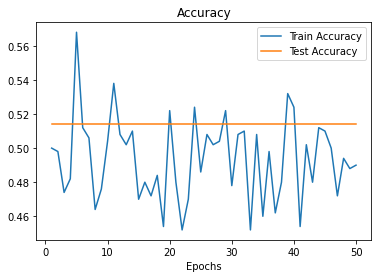

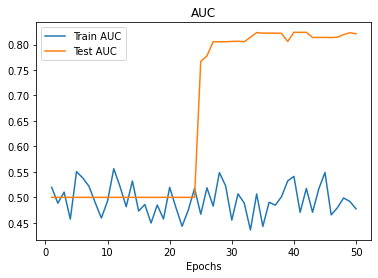

{'testAUC': 0.8211237610286465,
 'testAccuracy': 0.514,
 'testLoss': 0.005543710198253393,
 'trainAUC': 0.4774316389062225,
 'trainAccuracy': 0.49,
 'trainLoss': 0.005581877660006285}

In [ ]:
params['num_run'] = 1
params['num_epochs'] = 500

model = PPOMaskNet(k=1e-6, fine_tune=False, 
                   means_stds=mu_s,
                   dropout=0.2,
                   use_last_linear=True).to(device)
model.load_weights(original_weights)
multi_runs(model, learning_rate=1e-4, weight_decay=0, plots=True)

In [ ]:
obs_to_pass = xs[:20]
obs_tensor = torch.Tensor(obs_to_pass)
obs_tensor = obs_tensor.to(device)
y_hat = model.linear.forward(model.fc2.forward(model.fc1.forward(model.fwd_flat(obs_tensor)))).detach().cpu().numpy()

In [ ]:
list(zip(y_hat, ys[:20]))

[(array([0.1250588], dtype=float32), True),
 (array([0.12495093], dtype=float32), True),
 (array([0.12501633], dtype=float32), False),
 (array([0.12509783], dtype=float32), True),
 (array([0.1251204], dtype=float32), True),
 (array([0.12486207], dtype=float32), False),
 (array([0.12510873], dtype=float32), True),
 (array([0.12494467], dtype=float32), False),
 (array([0.12495093], dtype=float32), True),
 (array([0.12508222], dtype=float32), False),
 (array([0.12509783], dtype=float32), True),
 (array([0.12481277], dtype=float32), False),
 (array([0.12423654], dtype=float32), False),
 (array([0.12435955], dtype=float32), False),
 (array([0.12466638], dtype=float32), False),
 (array([0.12517461], dtype=float32), True),
 (array([0.12510873], dtype=float32), True),
 (array([0.12393266], dtype=float32), False),
 (array([0.12503144], dtype=float32), False),
 (array([0.12471586], dtype=float32), False)]

In [ ]:
params

{'agent_path': '/content/actorNet.keras',
 'env': 'doom',
 'num_epochs': 500,
 'num_run': 1,
 'num_train': 500,
 'num_val': 1000}

## Initialise Subnets Search with activation that obtained optimal AUC in previous experiment

We do this both as a sanity check as well as a potential improvement

In [ ]:
from sklearn import metrics 

acts = []
prefs = []

for data in all_raw_data:
    for i in range(data.observation.shape[0]):
        acts.append(np.copy(data.policy_info["activations"][i]))
        prefs.append((data.policy_info['satisfaction'].as_list()[i] > -6).astype(int))

acts = np.array(acts)
prefs = np.array(prefs)

def display_auc_info(xs, ys):
    
    def calc_auc(xs, ys, i):
        fpr, tpr, thresholds = metrics.roc_curve(ys, xs[:,i], pos_label=1)
        return metrics.auc(fpr, tpr)


    multi_runs_aucs = []
    for run_ix in range(50):
        xs, ys = shuffle(xs, ys)
        flat_xs = np.reshape(xs, (xs.shape[0], -1))
        aucs = []    
        
        for i in range(flat_xs.shape[1]):
            auc = calc_auc(flat_xs[:params['num_train']], ys[:params['num_train']], i)
            aucs.append(auc)  

        aucs = np.array(aucs)
        multi_runs_aucs.append(aucs)

    aucs = np.array(multi_runs_aucs)
    aucs = aucs.mean(axis=0)

    print("AUC from only picking a single activation")
    print(np.argmin(aucs), "train", 1-np.min(aucs), "val", 1-calc_auc(flat_xs[params['num_train']:], ys[params['num_train']:], np.argmin(aucs)))
    print(np.argmax(aucs), "train", np.max(aucs), "val", calc_auc(flat_xs[params['num_train']:], ys[params['num_train']:], np.argmax(aucs)))
  
display_auc_info(acts, prefs)

AUC from only picking a single activation
34 train 0.8168389427248516 val 0.8203183087179845
13 train 0.6133060108723783 val 0.6179787990821131


In [ ]:
best_act_index = 34
K = 66774 / 67152  # Num of weigths with all dense activations except one set to 0 / Number of total weights

params['num_epochs'] = 1
results = multi_runs(fine_tune=False, K=1, q_head_index=None, q_means_stds=q_mu_s, 
                     use_last_linear=False, init_from_act_index=best_act_index,
                     learning_rate=0.000, weight_decay=0.000, plots=False)

####results is a tuple where the first element is the dict
print(1-max(results[0]['testAUC']))

Train pass no. 1
Train pass no. 2
Train pass no. 3
Train pass no. 4
Train pass no. 5
0.8254807323986824
